# Retrieval Augmented Generation Pipeline

This is a small-scale large language modeling (LLM) project which focuses on building a Retrieval-Augmented Generation (RAG) pipeline. The primary goal is to provide richer, more relevant context for user queries. In that way, the hallucinations will be prevented, more accurate and up-to-date answers will be generated and LLM archtecture will be more specialized for specific topics.

This RAG pipeline specializes in deep learning theory and applications. It retrieves information from a curated Markdown file containing key concepts and methodologies in this domain, hosted on my [GitHub repository](https://github.com/GoktugGuvercin/The-Theory-of-Deep-Learning). This specialization allows the model to function as a subject matter expert within the field of deep learning.

When we look at the working structure of our RAG application, we would see that it operates in three consecutive steps, which makes it well-suited for LangChain. Nevertheless, this project intentionally uses LangGraph to offer greater control and visibility over the workflow, a choice that will be elaborated on later.

1. *Indexing*: The process begins by loading the external data from the GitHub source. This content is then divided into smaller, manageable chunks. Each chunk is converted into a numerical vector (embedding) and stored in a vector database.

2. *Retrieval*: This indexing enables efficient similarity searches, allowing us to retrieve the most relevant text passages for any given user query. A vector store is associated with an embedding model. When we pass a textual query to similarity search function of this vector store, its embedding is generated and its top similar chunks are retrieved.

3. *Generation:* Retrieved chunks are re-organized and inserted into a prompt. This prompt also includes the given query, and passed to chat model.

In this project, we will use embed and chat models provided by Cohere. To be able to access them, we need to open a Cohere account and create an API key.

In [ ]:
!pip install langgraph
!pip install langchain
!pip install langchain-cohere
!pip install langchain_community
!pip install langchain-text-splitters
!pip install "unstructured[md]"
!pip install "cohere==5.15.0"

In [2]:
import os
import getpass

from langchain_core.documents import Document
from langchain_community.document_loaders import UnstructuredURLLoader
from langchain_text_splitters import MarkdownHeaderTextSplitter
from langchain_cohere import CohereEmbeddings
from langchain_core.vectorstores import InMemoryVectorStore

from langchain import hub
from langchain.chat_models import init_chat_model
from langgraph.graph import START, StateGraph

from IPython.display import Image, display
from typing_extensions import TypedDict, List

# Cohere API Key

Environment variables are a way to store configuration details (like API keys) outside of your actual code. Here, we check whether we have an API key for Cohere. If it is not, we enter and set our API key for model accessibility.

In [3]:
if not os.getenv("COHERE_API_KEY"):
    os.environ["COHERE_API_KEY"] = getpass.getpass("Enter your Cohere API key: ")

Enter your Cohere API key: ··········


# Indexing

* ***Load:*** This is the first step of indexing. We load our external data sources by [*\"Document Loaders\"*](https://python.langchain.com/docs/concepts/document_loaders/). The data can be maintained in pdf, docx, structured sql table, or a web page; how you maintain your data only affects what kind of loader you will use.

* ***Split:*** Our data can be quite comprehensive and considerably long. In this case, we use [*text-splitters*](https://python.langchain.com/docs/concepts/text_splitters/) to break into smaller chunks. It helps us to store the data in a more effective way and avoid some pitfalls that we can be encountered while searching them in vector databases, information retrieval, and answer generation steps.

* ***Store:*** We store these chunks in [*vector databases*](https://python.langchain.com/docs/concepts/vectorstores/). At first, each chunk is indexed by an embedding vector to interpret its semantic context. Then, these chunks are loaded into the databases so that they can be searched over these embeddings. Embedding vectors are generated by [*representation models*](https://python.langchain.com/docs/concepts/embedding_models/).

### Loading Markdown Files

Compared to PDF and DOCX files, markdown is considerably less preferred approach to maintain text, paragraphs and passages. Nevertheless, LangChain is capable of providing distinct document loaders for any kind of document structure.

When markdown files are available on our local file system within the project workspace, the loader that we should use is [UnstructuredMarkdownLoader](https://python.langchain.com/docs/how_to/document_loader_markdown/). It is specifically designed to parse markdown syntax, and thereby helping to preserve the document's structure. To be able to use it, we need to install the necessary packages `nltk` and `"unstructured[md]"`. In contrast, accessing markdown files from web URLs, particularly from the platforms like GitHub, requires a slightly different approach. At this point, we opt for ***UnstructuredURLLoader***.

Unstructured URL loaders are designed to handle different types of contents that target URL points to. How the data is maintained is not important, it can cope with any type including HTML, PDF, Docx and Markdown. This loader sends a HTTP-GET request to each URL given as input, hands the raw bytes off to *\"unstructured partitioning pipeline\"*, and that pipeline will auto-detect the type of content, which helps to call the right parser. A comprehensive guide to all URL loaders is available in [here](https://python.langchain.com/docs/integrations/document_loaders/url/).


In [4]:
markdown_url = "https://raw.githubusercontent.com/GoktugGuvercin/The-Theory-of-Deep-Learning/refs/heads/main/README.md"
loader = UnstructuredURLLoader(urls=[markdown_url])
documents = loader.load()

### Split Documents into Chunks

LLM architectures are restricted with context window; the number of tokens that they can process is limited. That is why, long documents are split into smaller pieces called *chunks*. Additionally, these smaller, but coherent passages support retrieval granularity. In other words, the passages are more aligned with the information that answers our query. If these passages are configured to be too long, they may convert into a chapter that only tangentially mentions the topic.

The size of chunks has also important effect on their embedding quality. A single embedding vector for vast amount of text might average out the meaning, which makes it less effective at representing specific details and nuances within the chapter, which is called *dilution*. On the other hand, in too short chunks, it is highly possible to lack sufficient context for an embedding model to capture meaningful semantics. For more detailed explanation, you can check [this](https://github.com/GoktugGuvercin/The-Theory-of-Deep-Learning?tab=readme-ov-file#why-do-we-split-the-documents-into-smaller-chunks-for-vector-databases-).

How we will approch this problem and what kind of methodology we will use to split the text are the key consideration. At this point, since we have specific markdown structure, we will use `MarkdownHeaderTextSplitter`.

In [5]:
splitter = MarkdownHeaderTextSplitter(
    headers_to_split_on=[("#", "Header 1"), ("##", "Header 2")],
    strip_headers=False,
)

chunks = splitter.split_text(documents[0].page_content)

### Embeddings Models and Vector Datastores

<ins>***Embedding Models:***</ins>

Embedding models are used for generating dense vector representations to capture the context and semantic meaning of text passages, sentences, or documents. By calculating the distance or similarity between these vectors, we can quantitatively measure how related different pieces of text are. This capability is fundamental for applications like *semantic search*, which finds documents relevant to a query based on meaning rather than just keyword matching, and *recommender systems*, which suggest items similar to those a user has previously interacted with.

Since embedding vectors are the representative of text passages in terms of  semantic meaning, we can use them to group or cluster these passages with respect to their topic or context. This is actually a typical example of unsupervised learning paradigm where *clustering algorithms* can be used. Besides, for *sentiment analysis* and *text classification* tasks, these embeddings can be possibly used. For example, qwen3 embedding model and its training strategy are tailored for asymmetrical semantic search; that is why, it achieves the best results in re-ranking and retrieval tasks of MTEB table, but small performance decrease happens in summarization, classification and clustering sections.

<ins>***Vector Datastores:***</ins>

Vectorstores are specialized database systems designed to store embedding vectors, which act as dense numerical fingerprints representing a piece of data, such as text passages, audio records, or images. Their main functionality is not only to store these embeddings along with original data, but also to provide the ability to index them efficiently and query them for information retrieval and similarity search. From these aspects, vectorstores become an important asset for semantic search engines, retrieval augmented generation (RAG) applications with LLMs, and also recommendation systems.

In [6]:
embedding = CohereEmbeddings(
    cohere_api_key=os.environ["COHERE_API_KEY"],
    model="embed-v4.0"
)

vectorstore = InMemoryVectorStore(embedding)
chunk_ids = vectorstore.add_documents(chunks)

# Retrieval and Generation

This section outlines the design of the retrieval and augmentation logic. The process initiates when a user submits a question, which serves as the query. This query is at first transformed into an embedding vector to be searched on in-memory vectorstore. As a result of this search, the documents semantically related to the user's question are retrieved. Finally, these retrieved documents, along with the original question, are combined in a prompt to be passed to out LLM model for the generation of an answer.

[LangChain Prompt Hub](https://smith.langchain.com/hub/), accessed by `langchain.hub`, is a central repository where people can share, discover, and use high-quality, pre-built prompt templates. Here, we can find well-engineered prompts for specific tasks, each of which is actually specified by a unique identifier. The `hub` refers to central online repository where all those prompts are stored. The function `pull()` downloads specific prompt from the hub into our code. At this point, ***\"rlm/rag-prompt\"*** is used as unique identifier in which we are downloading *\"rag-prompt\"* created by *\"rlm\"* user.

```
You are an assistant for question-answering tasks. Use the following pieces of
retrieved context to answer the question. If you don't know the answer, just
say that you don't know. Use three sentences maximum and keep the answer concise.

Question: {question}
Context: {context}
Answer:
```

When we print the downloaded prompt, we see the one presented above. This prompt consists of multiple sub-sections that we try to benefit from so as to control how to proceed the conversation with LLM model. Let's investigate each of them:

1. ***Setting the Persona:***
    - *Instruction:* "You are an assistant for question-answering tasks."
    - *Purpose:* This tells the model what kind of job it is supposed to do. It sets the context for the entire mutual interaction, ensuring it behaves like a helpful assistant rather than, for example, a creative writer or a chatbot trying to have a casual conversation.

2. ***Defining Core Rule:***
    - *Instruction:* "Use the following pieces of retrieved context to answer the question."
    - *Purpose:* This command defines how the model answer the given questions. Instead of using its own internal (and potentially outdated or incorrect) knowledge, the model is directed to base its answer on the information provided in `context` section. This process is called grounding the model in your data.

3. ***Escape Hatch:***
    - *Instruction:* "If you don't know the answer, just say that you don't know."
    - *Purpose:* This is a specific safety guardrail. It tells the model how to behave if the provided context doesn't contain the answer. Without this, our LLM architecture can try to guess or hallucinate an answer, leading to incorrect information.

4. ***Regulating Output:***
    - *Instruction:* "Use three sentences maximum and keep the answer concise."
    - *Purpose:* This controls the format and length of the response.


The sections `question` and `context` will be replaced by our inputs, while answer block will be completed by the response that the model will generate.

In [7]:
# our llm model
llm = init_chat_model("command-a-03-2025", model_provider="cohere")

# our target prompt to be filled with context and query
prompt = hub.pull("rlm/rag-prompt")

question = "my question"
context = "retrieved documents"

example_message = prompt.invoke(
    {"context": f"{context}",
     "question": f"{question}"}
).to_messages()

print(example_message)

/usr/local/lib/python3.11/dist-packages/langsmith/client.py:272: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(


[HumanMessage(content="You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know. Use three sentences maximum and keep the answer concise.\nQuestion: my question \nContext: retrieved documents \nAnswer:", additional_kwargs={}, response_metadata={})]


# LangGraph

We will use LangGraph to implement and develop our application logic, where we bring retrieval ang generation steps together to construct a robust connection between them. At this point, we need to define and determine 3 components:

1. The state of application
2. The nodes of application (actions or application steps)
3. The edges and control flow of application

## 1. State:

The definition of the state relies on the type and scope of the application. However, its main ingredients commonly comprise <ins>***the input given to the application***</ins>, <ins>***the data processed and transferred between application steps***</ins>, and <ins>***generated output***</ins>. In this case, we keep track of input question, retrieved context, and generated answer in state variable.  

In [8]:
class State(TypedDict):
    question: str
    context: List[Document]
    answer: str

## 2. Nodes:

We have only 2 application steps, which are ***retrieve*** and ***generation***. These actions are proceeeded sequentially. That is why, our application logic can be also implemented as a chain rather than a graph.

* ***Retrieve:*** By using our input question, we perform similarity search on vector store. It returns the most related chunks as a list of documents. This step refers to *context retrieval*.

* ***Generate:*** The retrieved context is a list of chunks. To put them in a usable format, we combine all those chunks in a string, each of which is separated from another one by new lines. Now, our context and question are ready to be included in message prompt. This prompt is passed to our chat model to generate a response.

In [9]:
def retrieve(state: State) -> dict:
    retrieved_docs = vectorstore.similarity_search(state["question"])
    return {"context": retrieved_docs}


def generate(state: State) -> dict:
    docs_content = "\n\n".join(chunk.page_content for chunk in state["context"])
    input_fields = {"question": state["question"],"context": docs_content}
    message = prompt.invoke(input_fields)
    response = llm.invoke(message)
    return {"answer": response.content}

## 3. Edges and Control Flow

Multiple nodes can be connected to one another in a sequential order. The `add_sequence()` function provides a convenient way to contruct this structure easily. It accepts a list of nodes as input, and the edges are constructed in the given order. `START` node is commonly used in LangGraph applications; it specifies where the invocation starts. In our application, it starts with the retrieval, so a virtual start node is instantiated and connected to `retrieve` node.

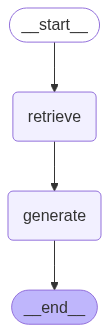

In [10]:
graph_builder = StateGraph(State).add_sequence([retrieve, generate])
graph_builder.add_edge(START, "retrieve")
graph = graph_builder.compile()

display(Image(graph.get_graph().draw_mermaid_png()))

In [14]:
result = graph.invoke({"question": "What do you know about weight sharing in deep learning?"})
context = "\n\n".join([doc.page_content for doc in result["context"]])

print(f'Context: {context}\n\n')
print(f'Answer: {result["answer"]}')

Context: ## Why is weight sharing so important ?  
Weight sharing enables us to reduce the number of trainable parameters in the neural architecture. This allows us to use more number of layers in order to learn more complicated relationships in the data, and the model even dont get larger enough.

## Do we have weight-sharing in FC and convolution layers ?  
Weight sharing is a concept of using same parameters to generate more than one output unit.  
In a fully-connected layer, each neuron has its own weights. In that case, a different set of weights is used to produce each output unit. On the other hand, a convolution layer convolves same kernel values with different parts of the input to generate multiple units in output feature map. So, more than one output unit relies on same kernel values.  
Each output unit relies on different set of parameters (FC Layer  
No Weight Sharing).  
Multiple output units relies on same set of parameters (Conv Layer  
Weight Sharing).

## What are con